In [89]:
%pip install pandas rdkit pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [90]:
import pandas as pd

df = pd.read_csv("compounds.csv", delimiter=';')
print("DataFrame head:")
display(df.head())

# Extract the relevant column (SMILES)
smiles_list = df["smiles"].tolist()
names_list = df["name"].tolist()


DataFrame head:


,name,smiles,pubmed
0,"Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate",CCOC(=O)C(CC1=CC(=C(C=C1)O)O)N,https://pubchem.ncbi.nlm.nih.gov/compound/1179...
1,"(S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)prop...",COC(=O)C(CC1=CC(=C(C=C1)O)O)N.Cl,https://pubchem.ncbi.nlm.nih.gov/compound/1013...
2,Etilevodopa,CCOC(=O)C(CC1=CC(=C(C=C1)O)O)N,https://pubchem.ncbi.nlm.nih.gov/compound/170345
3,Foslevodopa,C1=CC(=C(C=C1CC(C(=O)O)N)O)OP(=O)(O)O,https://pubchem.ncbi.nlm.nih.gov/compound/127766
4,Melevodopa,COC(=O)C(CC1=CC(=C(C=C1)O)O)N,https://pubchem.ncbi.nlm.nih.gov/compound/23497


In [91]:
from rdkit import Chem
from rdkit.Chem import AllChem

mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]

# Compute the Morgan fingerprints
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) 
                for mol in mols]

print(f"Computed {len(fingerprints)} fingerprints.")


Computed 8 fingerprints.


[16:10:16] DEPRECATION WARNING: please use MorganGenerator
[16:10:16] DEPRECATION WARNING: please use MorganGenerator
[16:10:16] DEPRECATION WARNING: please use MorganGenerator
[16:10:16] DEPRECATION WARNING: please use MorganGenerator
[16:10:16] DEPRECATION WARNING: please use MorganGenerator
[16:10:16] DEPRECATION WARNING: please use MorganGenerator
[16:10:16] DEPRECATION WARNING: please use MorganGenerator
[16:10:16] DEPRECATION WARNING: please use MorganGenerator


In [92]:
from rdkit.DataStructs import FingerprintSimilarity

# Create RDKit Mol and Morgan fingerprint for Levodopa
levodopa_smiles = "C1=CC(=C(C=C1CC(C(=O)O)N)O)O"
levodopa_mol = Chem.MolFromSmiles(levodopa_smiles)
levodopa_fp  = AllChem.GetMorganFingerprintAsBitVect(levodopa_mol, 2, nBits=1024)

# Compute Tanimoto similarity
similarities = []
for i, fp in enumerate(fingerprints):
    sim = FingerprintSimilarity(levodopa_fp, fp)
    similarities.append((i, sim))

[16:10:16] DEPRECATION WARNING: please use MorganGenerator


In [93]:
similarities_sorted = sorted(similarities, key=lambda x: x[1], reverse=True)

top_3 = similarities_sorted[:3]
print("Top 3 hits (index in dataset, similarity):")
for idx, sim_val in top_3:
    print(f" - Compound index {idx} == {names_list[idx]} with similarity {sim_val:.3f}")
    print("   SMILES:", smiles_list[idx])


Top 3 hits (index in dataset, similarity):
 - Compound index 5 == L-DOPA (sodium) with similarity 0.964
   SMILES: C1=CC(=C(C=C1CC(C(=O)O)N)O)O.[Na]
 - Compound index 4 == Melevodopa with similarity 0.676
   SMILES: COC(=O)C(CC1=CC(=C(C=C1)O)O)N
 - Compound index 6 == Tyrosine, 3-hydroxy-O-methyl- with similarity 0.667
   SMILES: COC1=C(C=C(C=C1)CC(C(=O)O)N)O


Similar Tanimoto means that the compounds have very similar level of overlap.

As we can see the L-DOPA (sodium) has very high similarity and thus we can assume that it is organically nearly identical to Levodopa.

As for the other 2 compounds they still have pretty high similarity, although not that we can say it has high similarity.

In [94]:
%pip install rdkit pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[16:10:18] DEPRECATION WARNING: please use MorganGenerator
[16:10:18] DEPRECATION WARNING: please use MorganGenerator
[16:10:18] DEPRECATION WARNING: please use MorganGenerator
[16:10:18] DEPRECATION WARNING: please use MorganGenerator
[16:10:18] DEPRECATION WARNING: please use MorganGenerator
[16:10:18] DEPRECATION WARNING: please use MorganGenerator
[16:10:18] DEPRECATION WARNING: please use MorganGenerator
[16:10:18] DEPRECATION WARNING: please use MorganGenerator
[16:10:18] DEPRECATION WARNING: please use MorganGenerator


<Figure size 1000x600 with 0 Axes>

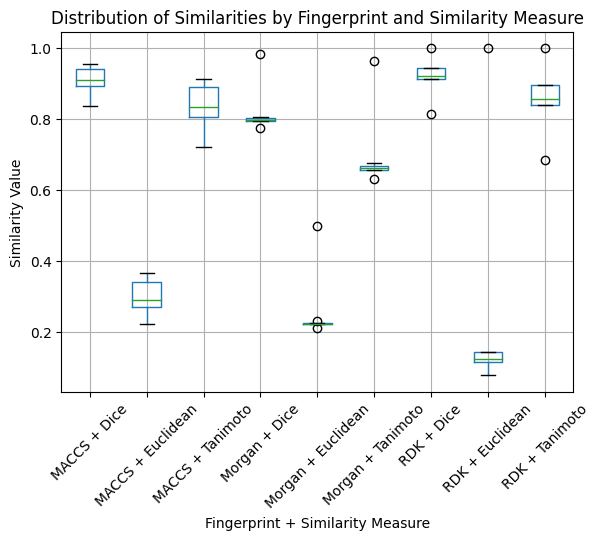

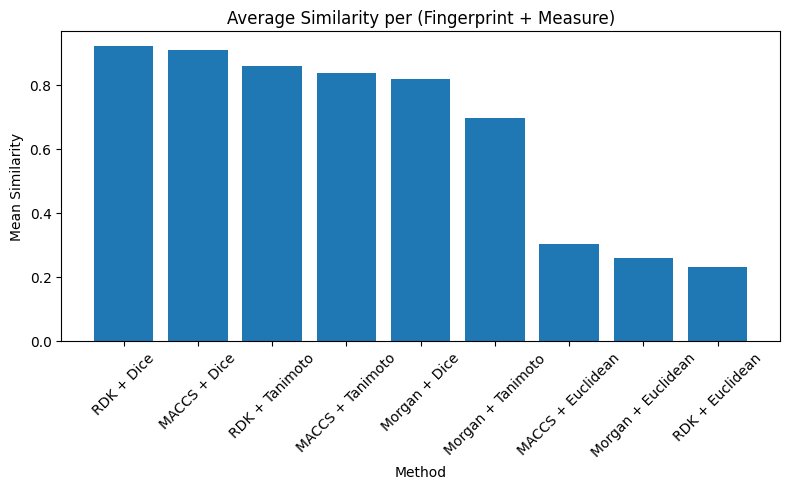

In [95]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.DataStructs import TanimotoSimilarity, DiceSimilarity

# Fingerprint generators:
def fp_morgan(mol):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

def fp_maccs(mol):
    return MACCSkeys.GenMACCSKeys(mol)

def fp_rdkit(mol):
    return Chem.RDKFingerprint(mol)  # RDKit topological fingerprint

fingerprint_functions = {
    'Morgan': fp_morgan,
    'MACCS':  fp_maccs,
    'RDK':    fp_rdkit
}

# Similarity measures:
def sim_tanimoto(fp1, fp2):
    return TanimotoSimilarity(fp1, fp2)

def sim_dice(fp1, fp2):
    return DiceSimilarity(fp1, fp2)

def sim_euclidean(fp1, fp2):
    """
    Convert the bit vector to a NumPy array of 0/1,
    compute the Euclidean distance, then invert it
    so it behaves like a "similarity" in [0..1).
    """
    arr1 = np.array(list(fp1.ToBitString()), dtype=int)
    arr2 = np.array(list(fp2.ToBitString()), dtype=int)
    dist = np.linalg.norm(arr1 - arr2)  # Euclidean distance
    # Simple transformation: similarity = 1 / (1 + distance)
    return 1.0 / (1.0 + dist)

similarity_functions = {
    'Tanimoto':  sim_tanimoto,
    'Dice':      sim_dice,
    'Euclidean': sim_euclidean
}

df = pd.read_csv("compounds.csv", delimiter=';')

# Convert SMILES to molecules
mols = [Chem.MolFromSmiles(smi) for smi in df["smiles"]]

# Reference compound: Levodopa
levodopa_smiles = "C1=CC(=C(C=C1CC(C(=O)O)N)O)O"
levodopa_mol = Chem.MolFromSmiles(levodopa_smiles)


# Precompute reference fingerprints (one per fingerprint type)
ref_fps = {}
for fp_name, fp_func in fingerprint_functions.items():
    ref_fps[fp_name] = fp_func(levodopa_mol)

results = []

# Loop over each compound
for idx, mol in enumerate(mols):
    if mol is None:
        continue
    
    # For each fingerprint type
    for fp_name, fp_func in fingerprint_functions.items():
        fp_compound = fp_func(mol)
        fp_ref = ref_fps[fp_name]
        
        for sim_name, sim_func in similarity_functions.items():
            sim_value = sim_func(fp_ref, fp_compound)
            results.append({
                "CompoundIndex": idx,
                "Fingerprint":   fp_name,
                "SimilarityMeasure": sim_name,
                "SimilarityValue": sim_value
            })

results_df = pd.DataFrame(results)
results_df.head(10)


results_df["FP+Measure"] = results_df["Fingerprint"] + " + " + results_df["SimilarityMeasure"]

plt.figure(figsize=(10, 6))
results_df.boxplot(column="SimilarityValue", by="FP+Measure", vert=True)
plt.title("Distribution of Similarities by Fingerprint and Similarity Measure")
plt.suptitle("")
plt.xlabel("Fingerprint + Similarity Measure")
plt.ylabel("Similarity Value")
plt.xticks(rotation=45)
plt.show()


mean_sims = results_df.groupby("FP+Measure")["SimilarityValue"].mean().reset_index()

mean_sims = mean_sims.sort_values("SimilarityValue", ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(mean_sims["FP+Measure"], mean_sims["SimilarityValue"])
plt.title("Average Similarity per (Fingerprint + Measure)")
plt.xlabel("Method")
plt.ylabel("Mean Similarity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

